In [330]:

"""Knowledge Distllation Method"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data.dataloader as Data
import torchvision #torchvision模块包括了一些图像数据集,如MNIST,cifar10等
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import os
os.environ['CUDA_LAUNCH_BLOCKING']="1"


In [331]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Loade dataset
data_dir = 'Desktop/data/data_1_N'
  
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
              for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128,                                             
                        shuffle=True, num_workers=0)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

# Determine the use of GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [332]:
print('\ntrain_loader:\n',dataloaders['train'].dataset)
print('\ntrain_data:\n',image_datasets['train'])
print('\nlen:\n',len(image_datasets['train']))
print('\nlen:\n',len(image_datasets['val']))


train_loader:
 Dataset ImageFolder
    Number of datapoints: 1470
    Root location: Desktop/data/data_1_N\train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

train_data:
 Dataset ImageFolder
    Number of datapoints: 1470
    Root location: Desktop/data/data_1_N\train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

len:
 1470

len:
 630


In [333]:
def plot_with_labels(lowDWeights, labels):
    plt.cla() #clear当前活动的坐标轴
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1] #把Tensor的第1列和第2列,也就是TSNE之后的前两个特征提取出来,作为X,Y
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9));
        #plt.text(x, y, s, backgroundcolor=c, fontsize=9)
        plt.text(x, y, str(s),color=c,fontdict={'weight': 'bold', 'size': 9}) #在指定位置放置文本
    plt.xlim(X.min(), X.max());
    plt.ylim(Y.min(), Y.max());
    plt.title('Visualize last layer');
    plt.show();
    plt.pause(0.01)

In [334]:
cnn = torch.load('Desktop/model_1016_2020/model/real-world_CLR/Net_KD_new-resnet18 -t_1.5_clr_triangular.pkl')
cnn =cnn.to(device)
print(cnn)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

C:\Users\DYU\anaconda3\envs\pytorch\lib\site-packages\torch\serialization.py:649: SourceChangeWarning: source code of class 'torchvision.models.alexnet.AlexNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\DYU\anaconda3\envs\pytorch\lib\site-packages\torch\serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\DYU\anaconda3\envs\pytorch\lib\site-packages\torch\serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by 

In [335]:

"""定义损失函数-这里默认是交叉熵函数"""

loss_func = torch.nn.CrossEntropyLoss()

"""初始化:优化器"""

optimizer = optim.SGD(cnn.classifier[6].parameters(), lr=1e-2, momentum=0.9)
#optimizer = optim.Adam(cnn.parameters(), lr=0.01)  #list(cnn.parameters())会给出一个参数列表,记录了所有训练参数(W和b)的数据
#optimizer =optim.Adam([ {'params': cnn.conv1.weight}, {'params': cnn.conv1.bias, 'lr': 0.002,'weight_decay': 0 },
#                         {'params': cnn.conv2.weight}, {'params': cnn.conv2.bias, 'lr': 0.002,'weight_decay': 0 },
#                         {'params': cnn.fc1.weight}, {'params': cnn.fc1.bias, 'lr': 0.002,'weight_decay': 0 },
#                         {'params': cnn.fc2.weight}, {'params': cnn.fc2.bias, 'lr': 0.002,'weight_decay': 0 },
#                         {'params': cnn.conv3.weight}, {'params': cnn.conv3.bias, 'lr': 0.002,'weight_decay': 0 },
#                         {'params': cnn.conv4.weight}, {'params': cnn.conv4.bias, 'lr': 0.002,'weight_decay': 0 },
#                         {'params': cnn.conv5.weight}, {'params': cnn.conv5.bias, 'lr': 0.002,'weight_decay': 0 },], lr=0.001, weight_decay=0.0001)


In [336]:
"""训练"""

def train(epoch):
    print('epoch {}'.format(epoch))
    #直接初始化为0的是标量,tensor调用item()将返回标量值
    train_loss = 0
    train_acc = 0
    #step是enumerate（）函数自带的索引，从0开始
    for step, (batch_x, batch_y) in enumerate(dataloaders['train']):
        # 把batch_x和batth_y移动到GPU
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        # 正向传播
        #out,_ = cnn(batch_x)
        out = cnn(batch_x)
        loss = loss_func(out, batch_y)
        train_loss += loss.item()
        # torch.max(tensor,dim:int):tensor找到第dim维度(第0维度是数据下标)上的最大值
        # return: 第一个Tensor是该维度的最大值,第二个Tensor是最大值相应的下标
        pred = torch.max(out, 1)[1]
        # 直接对逻辑量进行sum,将返回True的个数
        train_correct = (pred == batch_y).sum()
        train_acc += train_correct.item()
        if step % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, step * len(batch_x), len(dataloaders['train'].dataset),100. * step / len(dataloaders['train']), loss.item()))

        #反向传播
        optimizer.zero_grad() # 所有参数的梯度清零
        loss.backward() #即反向传播求梯度
        optimizer.step() #调用optimizer进行梯度下降更新参数
    print('Train Loss: {:.6f}, Acc: {:.6f}'.format(train_loss / (len(image_datasets['train'])), train_acc / (len(image_datasets['train']))))

from matplotlib import cm
try:
    from sklearn.manifold import TSNE; HAS_SK = True
except:
    HAS_SK = False; print('Please install sklearn for layer visualization')

In [337]:
"""准确率"""

def test():
    cnn.eval()
    eval_loss = 0
    eval_acc = 0
    # 打开imshow()交互模式:更新图像后直接执行以后的代码,不阻塞在plt.show()
    plt.ion()
    #无需反向传播计算梯度,不需要进行求导运算
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(dataloaders['val']):
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            #out,last_layer = cnn(batch_x)
            out = cnn(batch_x)
            loss = loss_func(out, batch_y)
            #loss =  += F.nll_loss(out, batch_y, size_average=False).item()
            eval_loss += loss.item()
            pred = torch.max(out, 1)[1]
            num_correct = (pred == batch_y).sum()
            eval_acc += num_correct.item()
            #若需绘图,将下面代码块注释去掉
            if step % 100 == 0:
                #t-SNE 是一种非线性降维算法，非常适用于高维数据降维到2维或者3维，进行可视化
                tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
                #最多只画500个点
                plot_only = 500
                #fit_transform函数把last_layer的Tensor降低至2个特征量,即3个维度(2个维度的坐标系)
                low_dim_embs = tsne.fit_transform(out.cpu().data.numpy()[:plot_only, :])
                labels = batch_y.cpu().numpy()[:plot_only]
                plot_with_labels(low_dim_embs, labels)
            #若需绘图,将上面代码块注释去掉 
    print('Test Loss: {:.6f}, Accuracy: {}/{} ({:.2f}%'.format(eval_loss / (len(image_datasets['val'])),eval_acc, len(image_datasets['val']) ,100.*eval_acc / (len(image_datasets['val']))))
    plt.ioff()



epoch 1
Train Epoch: 1 [0/1470 (0%)]	Loss: 5.941500
Train Loss: 0.014707, Acc: 0.641497


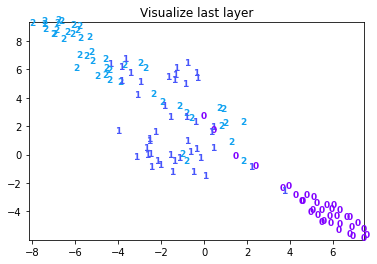

Test Loss: 0.006799, Accuracy: 511/630 (81.11%
epoch 2
Train Epoch: 2 [0/1470 (0%)]	Loss: 0.839235
Train Loss: 0.003897, Acc: 0.890476


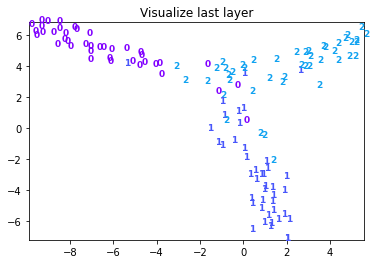

Test Loss: 0.006078, Accuracy: 545/630 (86.51%
epoch 3
Train Epoch: 3 [0/1470 (0%)]	Loss: 0.593304
Train Loss: 0.003326, Acc: 0.911565


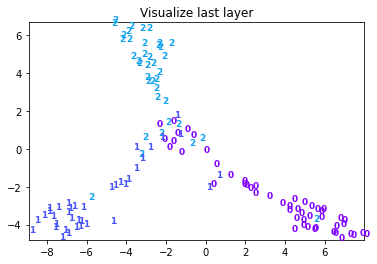

Test Loss: 0.004760, Accuracy: 546/630 (86.67%
epoch 4
Train Epoch: 4 [0/1470 (0%)]	Loss: 0.649542
Train Loss: 0.003022, Acc: 0.919728


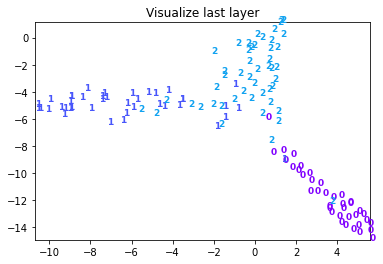

Test Loss: 0.004081, Accuracy: 554/630 (87.94%
epoch 5
Train Epoch: 5 [0/1470 (0%)]	Loss: 0.263359
Train Loss: 0.002531, Acc: 0.918367


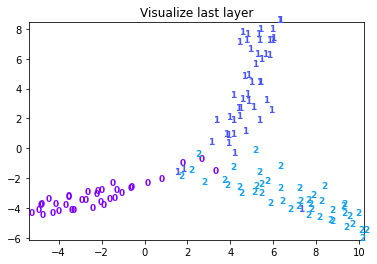

Test Loss: 0.003697, Accuracy: 555/630 (88.10%
epoch 6
Train Epoch: 6 [0/1470 (0%)]	Loss: 0.171135
Train Loss: 0.002183, Acc: 0.934014


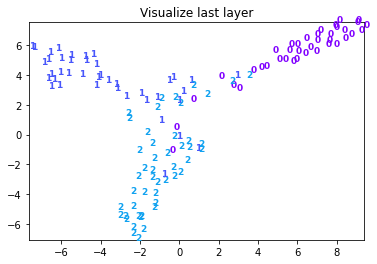

Test Loss: 0.003121, Accuracy: 561/630 (89.05%
epoch 7
Train Epoch: 7 [0/1470 (0%)]	Loss: 0.190525
Train Loss: 0.001584, Acc: 0.942857


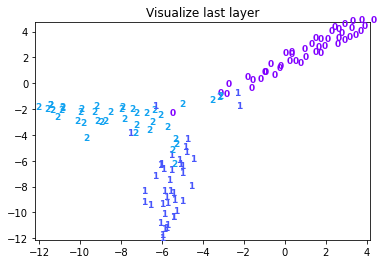

Test Loss: 0.002962, Accuracy: 561/630 (89.05%
epoch 8
Train Epoch: 8 [0/1470 (0%)]	Loss: 0.147974
Train Loss: 0.001832, Acc: 0.926531


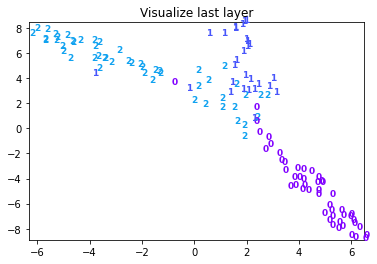

Test Loss: 0.002678, Accuracy: 568/630 (90.16%
epoch 9
Train Epoch: 9 [0/1470 (0%)]	Loss: 0.153565
Train Loss: 0.001344, Acc: 0.940136


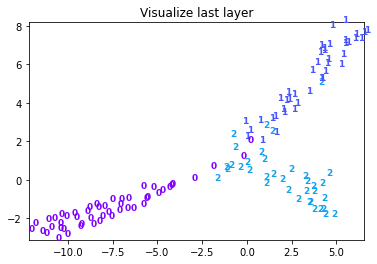

Test Loss: 0.002598, Accuracy: 566/630 (89.84%
epoch 10
Train Epoch: 10 [0/1470 (0%)]	Loss: 0.054280
Train Loss: 0.001000, Acc: 0.955782


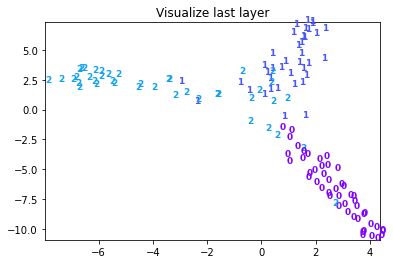

Test Loss: 0.002559, Accuracy: 563/630 (89.37%
epoch 11
Train Epoch: 11 [0/1470 (0%)]	Loss: 0.129419
Train Loss: 0.001314, Acc: 0.946939


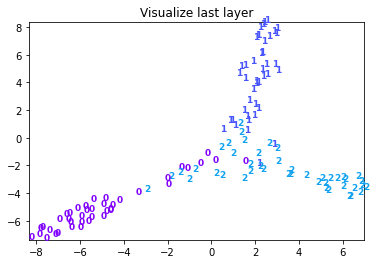

Test Loss: 0.002433, Accuracy: 565/630 (89.68%
epoch 12
Train Epoch: 12 [0/1470 (0%)]	Loss: 0.056904
Train Loss: 0.001145, Acc: 0.946939


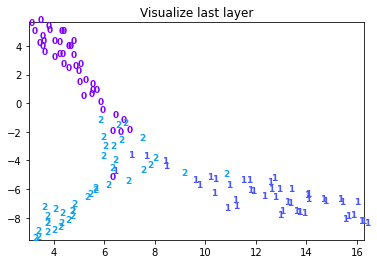

Test Loss: 0.002369, Accuracy: 570/630 (90.48%
epoch 13
Train Epoch: 13 [0/1470 (0%)]	Loss: 0.289684
Train Loss: 0.001136, Acc: 0.943537


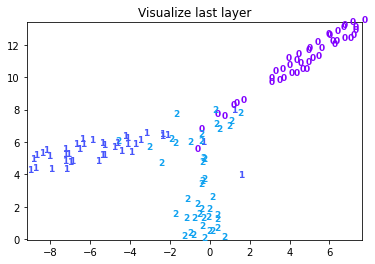

Test Loss: 0.002348, Accuracy: 572/630 (90.79%
epoch 14
Train Epoch: 14 [0/1470 (0%)]	Loss: 0.127927
Train Loss: 0.001209, Acc: 0.940816


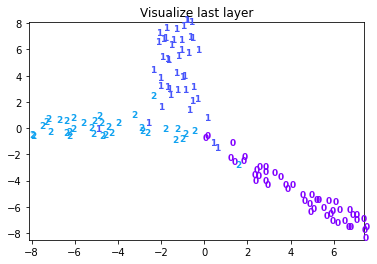

Test Loss: 0.002429, Accuracy: 568/630 (90.16%
epoch 15
Train Epoch: 15 [0/1470 (0%)]	Loss: 0.065787
Train Loss: 0.001031, Acc: 0.952381


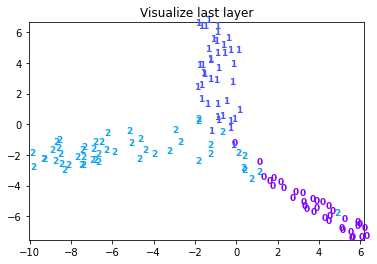

Test Loss: 0.002231, Accuracy: 574/630 (91.11%
epoch 16
Train Epoch: 16 [0/1470 (0%)]	Loss: 0.095168
Train Loss: 0.001006, Acc: 0.948980


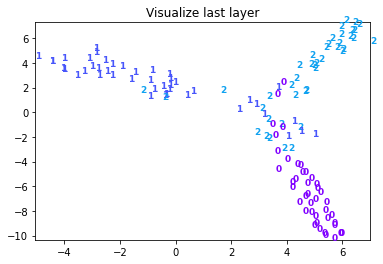

Test Loss: 0.002300, Accuracy: 573/630 (90.95%
epoch 17
Train Epoch: 17 [0/1470 (0%)]	Loss: 0.174768
Train Loss: 0.001041, Acc: 0.953061


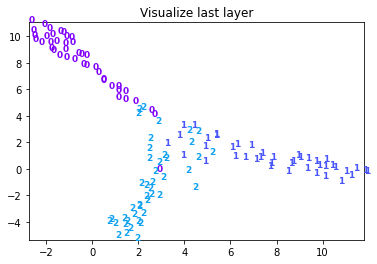

Test Loss: 0.002189, Accuracy: 572/630 (90.79%
epoch 18
Train Epoch: 18 [0/1470 (0%)]	Loss: 0.129824
Train Loss: 0.001027, Acc: 0.951020


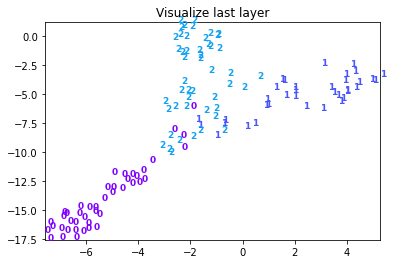

Test Loss: 0.002212, Accuracy: 570/630 (90.48%
epoch 19
Train Epoch: 19 [0/1470 (0%)]	Loss: 0.143211
Train Loss: 0.001138, Acc: 0.950340


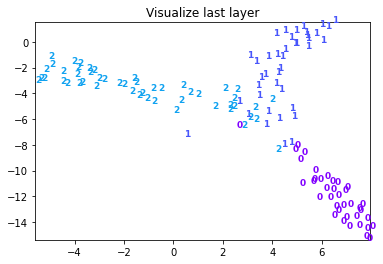

Test Loss: 0.002208, Accuracy: 568/630 (90.16%
epoch 20
Train Epoch: 20 [0/1470 (0%)]	Loss: 0.136926
Train Loss: 0.000923, Acc: 0.957143


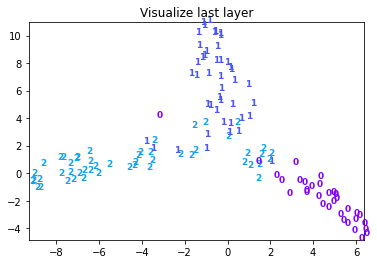

Test Loss: 0.002177, Accuracy: 575/630 (91.27%


In [338]:
for epoch in range(1, 21):
    train(epoch)
    test()